In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Utilities as U, Parsers as P
from mppi.Models import TwoLevelSystems as TLS
from mppi.Utilities import Constants as Const
from mppi.Utilities import Tools
import matplotlib.pyplot as plt
import numpy as np
import os, yaml

h_red = Const.Planck_reduced_ev_ps*1e3 # hbar in eV*fs
h = Const.Planck_ev_ps*1e3 # h in eV*fs

In [4]:
# Update data from the ismhpc server. The command has to be executed directly from the command line, 
# actually os.system does not recognize the files to be excluded. 
# The --dry-run option can be used to control the effects
# of the command before the real copy
dry_run = False
rsync_str = "rsync -rLptgoDzv --exclude={'*_fragment_*','*_fragments_*','*_CPU_*'} "
if dry_run: rsync_str += '--dry-run '
ssh_str = '-e ssh ismhpc:/work/dalessandro/OPTICAL_ORIENTATION/Echo_mechanisms_decay_time/PHOTON_ECO/ABS-IP_k1000_kspan0.06/ '
dest_path = 'ABS-IP_k1000_kspan0.06'
dest_path = os.path.abspath(dest_path)
dest_path = "'%s'"%dest_path
command = rsync_str+ssh_str+dest_path
print(command)
#os.system(command)

rsync -rLptgoDzv --exclude={'*_fragment_*','*_fragments_*','*_CPU_*'} -e ssh ismhpc:/work/dalessandro/OPTICAL_ORIENTATION/Echo_mechanisms_decay_time/PHOTON_ECO/ABS-IP_k1000_kspan0.06/ '/home/marco/Data/RICERCA/DFT AND MANY BODY/OPTICAL ORIENTATION/Echo mechanisms and decay time/PHOTON_ECO/ABS-IP_k1000_kspan0.06'


In [5]:
omp = 1
mpi = 16
sbatch_options = ['--partition=all12h'] #,'--ntasks-per-node=16']

In [6]:
code = C.YamboCalculator(omp=omp,mpi=mpi,executable='yambo_rt')
#code = C.YamboCalculator(omp=omp,mpi=mpi,executable='yambo_rt',scheduler='slurm',sbatch_options=sbatch_options)
code.global_options()

Initialize a Yambo calculator with scheduler direct


{'omp': 1,
 'mpi': 16,
 'mpi_run': 'mpirun -np',
 'executable': 'yambo_rt',
 'scheduler': 'direct',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'sbatch_options': [],
 'activate_BeeOND': True,
 'verbose': True}

# Computation of the IP Absorption spectrum

We compute the IP absorption spectrum using Yambo

In [7]:
# analysis with k sampling volume of 0.06 (1000 points)     
run_dir = 'ABS-IP_k1000_kspan0.06'
source_dir = 'NSCF/bnds_8-kpoints_1000-sampling_random_close_Gamma_kspan0.06.save'

In [8]:
Tools.build_SAVE(source_dir,run_dir,make_link=True)

SAVE folder already present in ABS-IP_k1000_kspan0.06. No operations performed.


In [9]:
h/250

0.016542670784

In [10]:
T2 = 250 # damping time in fs
eta = h / T2 # eta damping in eV 

inp = I.YamboInput('yambo -o c',folder=run_dir)
inp['variables']['LongDrXd'] = [[1.00,1.00,1.00],''] # electric field
inp['variables']['XfnQP_E'] = [[0.95477,1.00,1.00],''] # scissor
inp['variables']['DmRngeXd'] = [[eta/2,eta/2],'eV'] # damping range
inp['variables']['EnRngeXd'] = [[0,3],'eV'] # energy range
inp['variables']['ETStpsXd'] = [1000,''] # number of energy step
inp['variables']['BndsRnXd'] = [[2,8],''] # bands used for transitions
inp['variables']['QpntsRXd'] = [[1,1],''] # momentum transfer
inp

{'args': 'yambo -o c',
 'folder': 'ABS-IP_k1000_kspan0.06',
 'filename': 'yambo.in',
 'arguments': ['chi', 'optics'],
 'variables': {'X_Threads': [0.0, ''],
  'DIP_Threads': [0.0, ''],
  'ETStpsXd': [1000, ''],
  'Chimod': 'IP',
  'QpntsRXd': [[1, 1], ''],
  'BndsRnXd': [[2, 8], ''],
  'EnRngeXd': [[0, 3], 'eV'],
  'DmRngeXd': [[0.008271335392, 0.008271335392], 'eV'],
  'LongDrXd': [[1.0, 1.0, 1.0], ''],
  'XfnQP_E': [[0.95477, 1.0, 1.0], '']}}

In [11]:
name = 'ip_abs'
result = code.run(input=inp,name=name,run_dir=run_dir,skip=True)
result

Skip the run of ip_abs


{'output': ['ABS-IP_k1000_kspan0.06/ip_abs/o-ip_abs.eel_q1_ip',
  'ABS-IP_k1000_kspan0.06/ip_abs/o-ip_abs.eps_q1_ip'],
 'report': 'ABS-IP_k1000_kspan0.06/ip_abs/r-ip_abs_optics_chi',
 'dft': 'ABS-IP_k1000_kspan0.06/SAVE/ns.db1',
 'dipoles': 'ABS-IP_k1000_kspan0.06/ip_abs/ndb.dipoles'}

In [12]:
data = P.YamboParser(result)

In [13]:
#data = P.YamboParser(result['output'][0])

In [14]:
eps = data.data['eps_q1_ip']
energy = eps['col0']
eps_im = eps['col1']
eps_re = eps['col2']

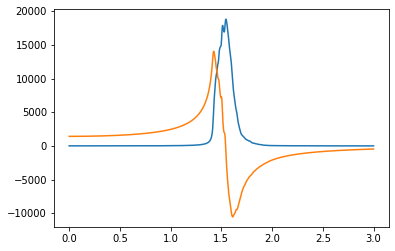

In [15]:
plt.plot(energy,eps_im)
plt.plot(energy,eps_re)